<a href="https://colab.research.google.com/github/c-w-m/anlp-tf2/blob/master/chapter5-nlg-with-transformer-gpt/rnn-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir char-rnn

In [13]:
cd char-rnn

/content/char-rnn


In [14]:
# select the 'news-headlines.tsv' file from you local drive to upload to colab
from google.colab import files
uploaded = files.upload()

Saving news-headlines.tsv to news-headlines.tsv


In [15]:
cd ..

/content


In [16]:
!ls

char-rnn  sample_data


# New Section

In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
import datetime
import time
import matplotlib.pyplot as plt

In [18]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
#tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################

1 Physical GPUs, 1 Logical GPU


In [9]:
#########################################
## DATA NORMALIZATION AND TOKENIZATION ##
#########################################

chars = sorted(set("abcdefghijklmnopqrstuvwxyz0123456789 -,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=()[]{}' ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
chars = list(chars)
EOS = '<EOS>'
UNK = "<UNK>"
PAD = "<PAD>"  # need to move mask to '0'index for Embedding layer
chars.append(UNK)
chars.append(EOS)  #end of sentence

chars.insert(0, PAD)  # now padding should get index of 0

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(chars)}
idx2char = np.array(chars)

def char_idx(c):
    # takes a character and returns an index
    # if character is not in list, returns the unknown token
    if c in chars:
        return char2idx[c]
    
    return char2idx[UNK]


data = []  # load into this list of lists 
MAX_LEN = 75  #maximum length of a headline 

In [19]:
#/content/char-rnn/news-headlines.tsv
#./char-rnn/news-headlines.tsv
with open("/content/char-rnn/news-headlines.tsv", "r") as file:
    lines = csv.reader(file, delimiter='\t')
    for line in lines:
        hdln = line[0]
        cnvrtd = [char_idx(c) for c in hdln[:-1]]  # convert to number
        if len(cnvrtd) >= MAX_LEN:
            cnvrtd = cnvrtd[0:MAX_LEN-1]
            cnvrtd.append(char2idx[EOS])
        else:
            cnvrtd.append(char2idx[EOS])
            # add padding tokens
            remain = MAX_LEN - len(cnvrtd)
            if remain > 0:
                for i in range(remain):
                    cnvrtd.append(char2idx[PAD])
        data.append(cnvrtd)
print("**** Data file loaded ****")

**** Data file loaded ****


In [20]:
# now convert to numpy array
np_data = np.array(data)

# for training, we use one character shifted data
np_data_in = np_data[:, :-1]
np_data_out = np_data[:, 1:]

# Create TF dataset
x = tf.data.Dataset.from_tensor_slices((np_data_in, np_data_out))

**** Model Instantiated ****
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (256, None, 256)          24576     
_________________________________________________________________
gru (GRU)                    (256, None, 1024)         3938304   
_________________________________________________________________
dense (Dense)                (256, None, 96)           98400     
Total params: 4,061,280
Trainable params: 4,061,280
Non-trainable params: 0
_________________________________________________________________
None
**** Start Training ****
Epoch 1/150
2434/2434 [==============================] - 138s 49ms/step - loss: 1.5964
Epoch 2/150
2434/2434 [==============================] - 117s 48ms/step - loss: 1.0058
Epoch 3/150
2434/2434 [==============================] - 120s 49ms/step - loss: 0.9533
Epoch 4/150
2434/2434 [==============================] -

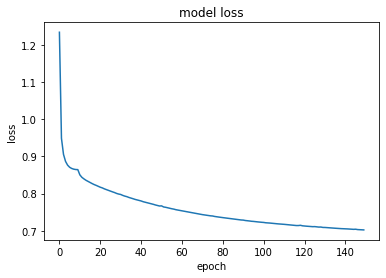

In [21]:
##################
#### MODELING ####
##################

# Length of the vocabulary in chars
vocab_size = len(chars)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

#batch size
BATCH_SIZE=256

# create tf.DataSet
x_train = x.shuffle(100000, reshuffle_each_iteration=True
                   ).batch(BATCH_SIZE, drop_remainder=True)

# define the model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

model = build_model(
                  vocab_size = vocab_size,
                  embedding_dim=embedding_dim,
                  rnn_units=rnn_units,
                  batch_size=BATCH_SIZE)

print("**** Model Instantiated ****")
print(model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = 'adam', loss = loss)

# Custom Callback for Learning Rate Decay
class LearningRateScheduler(tf.keras.callbacks.Callback):
  """Learning rate scheduler which decays the learning rate"""

  def __init__(self, init_lr, decay, steps, start_epoch):
    super().__init__()
    self.init_lr = init_lr  #initial learning rate
    self.decay = decay  # how sharply to decay
    self.steps = steps  # total number of steps of decay
    self.start_epoch = start_epoch  # which epoch to start decaying

  def on_epoch_begin(self, epoch, logs=None):
    if not hasattr(self.model.optimizer, 'lr'):
      raise ValueError('Optimizer must have a "lr" attribute.')
    # Get the current learning rate from model's optimizer.
    lr = float(tf.keras.backend.get_value(
                        self.model.optimizer.lr))
    if(epoch >= self.start_epoch):
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.init_lr / (1 + self.decay * (epoch / self.steps))
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, 
                                   scheduled_lr)
        print('\nEpoch %05d: Learning rate is %6.8f.' % (epoch, 
                                                         scheduled_lr))


# Setup checkpoints 
#dynamically build folder names
dt = datetime.datetime.today().strftime("%Y-%b-%d-%H-%M-%S")

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints/'+ dt

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

print("**** Start Training ****")
EPOCHS=150
lr_decay = LearningRateScheduler(0.001, 4., EPOCHS, 10)
start = time.time()
history = model.fit(x_train, epochs=EPOCHS, 
                    callbacks=[checkpoint_callback, lr_decay])
print("**** End Training ****")
print("Training time: ", time.time()- start)

# Plot accuracies
lossplot = "loss-" + dt + ".png"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(lossplot)

print("Saved loss to: ", lossplot)